Data Plotting Fixes
===

We modified the processing script to correctly handle 12-bit images in the DICOM files, and output them as 16-bit PNG images. However we're having some problem with displaying the reprocessed images. This workbook is intended to examine these images and the autoencoder output corresponding to them, to determine if there is anything that can be done with them.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import math
import numpy
import collections

from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import os

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 16
epochs = 80
learning_rate = 1e-4

#code_size = 100
code_sides = [16]

convolution_filters = 4

#image_count = 300
image_count = -1

validation_split = 0.9

## Dataset

Using a custom dataset class to load the images:

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("F")
        tensor_image = self.transform(image)
        return tensor_image

In [5]:
from torchvision.datasets import ImageFolder

from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
#    torchvision.transforms.Lambda(lambda image: torch.from_numpy(numpy.array(image).astype(numpy.float32)).unsqueeze(0))
    torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.0,65535.0)
#     torchvision.transforms.Resize((height,width)),
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/256/detector"
#train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
train_dataset = CustomDataSet(root_dir, transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

dataset_len = len(train_dataset_subset)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor((1.0 - validation_split) * dataset_len))

dataset_size = len(train_dataset_subset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
    
train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = valid_sampler
)

data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": split, "val": val_len}
print(split)
print(val_len)

3309
367


Plot a few of the images

(256, 256) 1.0 0.0 0.13029957 0.15910603


C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


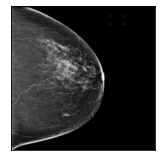

In [6]:

plt.figure(figsize=(25, 9))
# display original
ax = plt.subplot(3, 5, 1)
#print(train_dataset_subset[735][0])
copyback = train_dataset_subset[735][0].numpy()
print(copyback.shape, copyback.max(), copyback.min(), copyback.mean(), copyback.std())
#print(copyback)
#plt.imshow(copyback.reshape(height, width), vmin=0, vmax=65535.0)
plt.imshow(copyback.reshape(height, width))
#plt.imshow(copyback)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [7]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)
model_path = "../../Data/OPTIMAM_NEW/model0.pt"
model = torch.load(model_path,map_location=torch.device("cuda"))
model.eval()

SplitAutoencoder(
  (encoder): ExtensibleEncoder(
    (cnnStage): Sequential(
      (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU()
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (fc1): Linear(in_features=65536, out_features=256, bias=True)
  )
  (decoder): ExtensibleDecoder(
    (cnnStage): Sequential(
      (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (upsample3): Upsample(scale_factor=2.0, mo

Let's extract some test examples to reconstruct using our trained autoencoder.

In [9]:
test_dataset = CustomDataSet(root_dir, transform) # same transform as we used for the training, for compatibility

if (image_count == -1):
    test_dataset_subset = test_dataset
else:
    test_dataset_subset = torch.utils.data.Subset(test_dataset, numpy.random.choice(len(test_dataset), image_count, replace=False))

test_loader = torch.utils.data.DataLoader(
    test_dataset_subset, batch_size=5, shuffle=True
)

test_example_sets = [None] * len(code_sides)
code_sets = [None] * len(code_sides)
reconstruction_sets = [None] * len(code_sides)

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [10]:
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.to(device)
        n_codes = model.encoder(test_examples)
        reconstruction = model(test_examples)
        break;
    test_example_sets = test_examples
    code_sets = n_codes
    reconstruction_sets = reconstruction

            

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [4, 1, 3, 3], but got 3-dimensional input of size [1, 256, 256] instead

In [ ]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = test_example_sets
        copyback = test_examples[index].cpu()
        #plt.imshow(copyback.numpy().reshape(height, width), vmin=0, vmax=4096)
        #plt.imshow(copyback.reshape(height, width))
        plt.imshow(copyback)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + 1 + number)
        codes = code_sets
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.numpy().reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 6 + number)
        reconstruction = reconstruction_sets
        recon_copyback = reconstruction[index].cpu()
        #plt.imshow(recon_copyback.reshape(height, width), vmin=0, vmax=4096)
        plt.imshow(recon_copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "output"+str(0)+".png" 
    plt.savefig(out_path)
    plt.show()